***Milestone 4***

**Import + paths**

In [12]:
import os
import glob
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

PROJECT_DIR = Path.cwd()

IMAGE_DIR = PROJECT_DIR / "yolov5" / "yolo_results" / "panda_boxes3"
LABEL_DIR = IMAGE_DIR / "labels"
CROP_DIR = PROJECT_DIR / "cropped_pandas"
VG_DIR = PROJECT_DIR / "gan_panda" / "vg_dataset"
CHECKPOINT_DIR = PROJECT_DIR / "gan_panda" / "checkpoints_cut"
CHECKPOINT_DIR.mkdir(exist_ok=True)

print("Using directories:")
print("IMAGE_DIR=", IMAGE_DIR)
print("LABEL_DIR=", LABEL_DIR)
print("CROP_DIR=", CROP_DIR)
print("VG_DIR=", VG_DIR)

# Set device and its mps, so I couldn't use pretrained GANs on Mac because all of them is using CUDA which works only on Nvidia GPUs.
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("DEVICE =", DEVICE)

Using directories:
IMAGE_DIR= /Users/semkustikov/project/mil4/yolov5/yolo_results/panda_boxes3
LABEL_DIR= /Users/semkustikov/project/mil4/yolov5/yolo_results/panda_boxes3/labels
CROP_DIR= /Users/semkustikov/project/mil4/cropped_pandas
VG_DIR= /Users/semkustikov/project/mil4/gan_panda/vg_dataset
DEVICE = mps


**Example of yolov5 output**

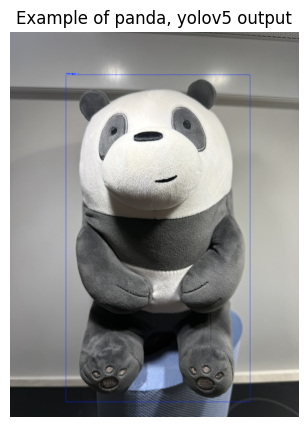

In [39]:
img_path = glob.glob("yolov5/yolo_results/panda_boxes3/IMG_2085.jpg")[0]

image = Image.open(img_path)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title("Example of panda, yolov5 output")
plt.axis("off")
plt.show()

**Read + Crop panda pictures from yolov5**

Total original images: 220
Cropped pandas: 202


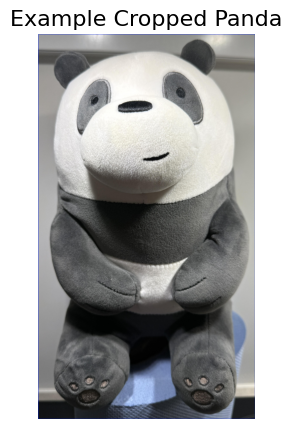

In [ ]:
def load_yolo_boxes(label_path, img_w, img_h):
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            cls_id, xc, yc, w, h = map(float, parts[:5])

            xc *= img_w
            yc *= img_h
            w *= img_w
            h *= img_h

            x1 = int(xc - w/2)
            y1 = int(yc - h/2)
            x2 = int(xc + w/2)
            y2 = int(yc + h/2)

            x1 = max(0, min(x1, img_w-1))
            y1 = max(0, min(y1, img_h-1))
            x2 = max(0, min(x2, img_w))
            y2 = max(0, min(y2, img_h))

            boxes.append((x1, y1, x2, y2))

    return boxes

image_paths = sorted(glob.glob(str(IMAGE_DIR / "*.JPG")))
print("Total original images:", len(image_paths))

CROP_DIR.mkdir(exist_ok=True)

crop_count = 0
first_crop_path = None

for img_path in image_paths:
    filename = Path(img_path).stem
    label_path = LABEL_DIR / f"{filename}.txt"

    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    boxes = load_yolo_boxes(label_path, W, H)
    if not boxes:
        continue

    save_folder = CROP_DIR / filename
    save_folder.mkdir(parents=True, exist_ok=True)

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        crop = img.crop((x1, y1, x2, y2))
        out_path = save_folder / f"{filename}_panda_{i}.jpg"
        crop.save(out_path)

        if first_crop_path is None:
            first_crop_path = out_path

        crop_count += 1

print("Cropped pandas:", crop_count)

if first_crop_path:
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(first_crop_path))
    plt.title("Example Cropped Panda", fontsize=16)
    plt.axis("off")
    plt.show()

**CUT-GAN dataset + architecture**

I used CUT-GAN styler which learns on Van Gogh paintings, because I couldn't use pretrained GANs on Mac because all of them is using CUDA which works only on Nvidia GPUs. I used as reference different GANs on github + guides

In [15]:
IMG_SIZE = 256
BATCH_SIZE = 1
LR = 2e-4
EPOCHS = 40

class ImageDataset(Dataset):
    def __init__(self, root, size):
        root = Path(root)
        self.paths = [p for p in root.rglob("*") if p.suffix.lower() in (".jpg",".png",".jpeg")]
        if not self.paths:
            raise RuntimeError(f"No images in {root}")

        self.transform = transforms.Compose([
            transforms.Resize((size+50, size+50)),
            transforms.RandomCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2,0.2,0.2),
            transforms.RandomRotation(5),
            transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, n_blocks=9):
        super().__init__()
        ngf = 64

        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, ngf, 7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]

        mult = 1
        for _ in range(2):
            layers += [
                nn.Conv2d(ngf*mult, ngf*mult*2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf*mult*2),
                nn.ReLU(True),
            ]
            mult *= 2

        for _ in range(n_blocks):
            layers.append(ResnetBlock(ngf * mult))

        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(ngf*mult, ngf*mult//2, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(ngf*mult//2),
                nn.ReLU(True)
            ]
            mult //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, 3, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        ndf = 64

        seq = [
            nn.Conv2d(3, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, True)
        ]

        mult = 1
        for n in [2, 4, 8]:
            seq += [
                nn.Conv2d(ndf*mult, ndf*n, 4, 1 if n==8 else 2, 1),
                nn.InstanceNorm2d(ndf*n),
                nn.LeakyReLU(0.2, True)
            ]
            mult = n

        seq += [nn.Conv2d(ndf*8, 1, 4, 1)]
        self.model = nn.Sequential(*seq)

    def forward(self, x):
        return self.model(x)

**Traiing our GAN**

In [ ]:
def train_cut():
    print("Loading datasets...")
    dlA = DataLoader(ImageDataset(CROP_DIR, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True)
    dlB = DataLoader(ImageDataset(VG_DIR, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True)

    G = Generator().to(DEVICE)
    D = PatchDiscriminator().to(DEVICE)

    mse = nn.MSELoss()
    l1 = nn.L1Loss()

    opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        for a_img, b_img in tqdm(zip(dlA, dlB), total=min(len(dlA), len(dlB))):
            a_img = a_img.to(DEVICE)
            b_img = b_img.to(DEVICE)

            # --------- Train D ---------
            opt_D.zero_grad()
            fake = G(a_img).detach()

            loss_D = (
                mse(D(b_img), torch.ones_like(D(b_img))) +
                mse(D(fake), torch.zeros_like(D(fake)))
            ) * 0.5

            loss_D.backward()
            opt_D.step()

            # --------- Train G ---------
            opt_G.zero_grad()
            fake = G(a_img)

            loss_G = mse(D(fake), torch.ones_like(D(fake))) + l1(fake, a_img) * 2.0

            loss_G.backward()
            opt_G.step()

        ckpt = CHECKPOINT_DIR / f"G_epoch_{epoch+1:03}.pth"
        torch.save(G.state_dict(), ckpt)
        print("Saved checkpoint:", ckpt)

train_cut()


Loading datasets...

Epoch 1/40


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_001.pth

Epoch 2/40


100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_002.pth

Epoch 3/40


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_003.pth

Epoch 4/40


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_004.pth

Epoch 5/40


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_005.pth

Epoch 6/40


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_006.pth

Epoch 7/40


100%|██████████| 12/12 [00:03<00:00,  3.34it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_007.pth

Epoch 8/40


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_008.pth

Epoch 9/40


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_009.pth

Epoch 10/40


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_010.pth

Epoch 11/40


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_011.pth

Epoch 12/40


100%|██████████| 12/12 [00:03<00:00,  3.22it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_012.pth

Epoch 13/40


100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_013.pth

Epoch 14/40


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_014.pth

Epoch 15/40


100%|██████████| 12/12 [00:03<00:00,  3.26it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_015.pth

Epoch 16/40


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_016.pth

Epoch 17/40


100%|██████████| 12/12 [00:03<00:00,  3.23it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_017.pth

Epoch 18/40


100%|██████████| 12/12 [00:03<00:00,  3.19it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_018.pth

Epoch 19/40


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_019.pth

Epoch 20/40


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_020.pth

Epoch 21/40


100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_021.pth

Epoch 22/40


100%|██████████| 12/12 [00:03<00:00,  3.17it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_022.pth

Epoch 23/40


100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_023.pth

Epoch 24/40


100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_024.pth

Epoch 25/40


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_025.pth

Epoch 26/40


100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_026.pth

Epoch 27/40


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_027.pth

Epoch 28/40


100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_028.pth

Epoch 29/40


100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_029.pth

Epoch 30/40


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_030.pth

Epoch 31/40


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_031.pth

Epoch 32/40


100%|██████████| 12/12 [00:04<00:00,  2.99it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_032.pth

Epoch 33/40


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_033.pth

Epoch 34/40


100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_034.pth

Epoch 35/40


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_035.pth

Epoch 36/40


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_036.pth

Epoch 37/40


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_037.pth

Epoch 38/40


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_038.pth

Epoch 39/40


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_039.pth

Epoch 40/40


100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Saved checkpoint: /Users/semkustikov/project/mil4/gan_panda/checkpoints_cut/G_epoch_040.pth


**Styiling our pandas**

In [27]:
OUTPUT_DIR = PROJECT_DIR / "styled_pandas_vg"
OUTPUT_DIR.mkdir(exist_ok=True)

CHECKPOINT = CHECKPOINT_DIR / "G_epoch_040.pth"

to_tensor = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

to_pil = transforms.Compose([
    transforms.Normalize(mean=(-1,-1,-1), std=(2,2,2)),
    transforms.ToPILImage()
])

def load_generator():
    G = Generator().to(DEVICE)
    G.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))
    G.eval()
    return G

G = load_generator()

styled_examples = []

for img_path in CROP_DIR.rglob("*.jpg"):
    rel = img_path.relative_to(CROP_DIR)
    out_path = OUTPUT_DIR / rel
    out_path.parent.mkdir(parents=True, exist_ok=True)

    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    t = to_tensor(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        fake = G(t)[0].cpu()

    styled = to_pil(fake).resize((w, h))
    styled.save(out_path)

    if len(styled_examples) < 2:
        styled_examples.append((img, styled))

print("Stylization complete")


Stylization complete


**Before and after stylization**

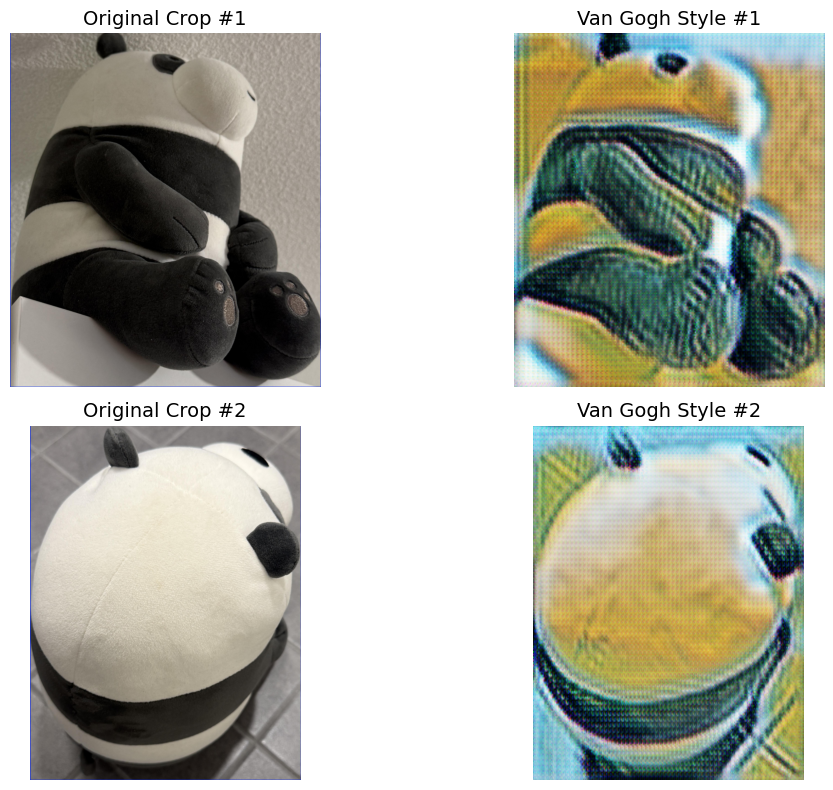

In [ ]:
pairs_to_show = styled_examples[:2]

plt.figure(figsize=(12, 8))

for i, (orig, styled) in enumerate(pairs_to_show):
    plt.subplot(2, 2, i*2 + 1)
    plt.imshow(orig)
    plt.title(f"Original Crop #{i+1}", fontsize=14)
    plt.axis("off")

    plt.subplot(2, 2, i*2 + 2)
    plt.imshow(styled)
    plt.title(f"Van Gogh Style #{i+1}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [41]:
FINAL_DIR = PROJECT_DIR / "final_images"
FINAL_DIR.mkdir(exist_ok=True)

print("Pasting stylized pandas back into original photos...")

for orig_path in IMAGE_DIR.glob("*.JPG"):
    img_name = orig_path.stem
    label_path = LABEL_DIR / f"{img_name}.txt"

    orig_img = Image.open(orig_path).convert("RGB")
    W, H = orig_img.size

    boxes = load_yolo_boxes(label_path, W, H)
    if not boxes:
        continue

    styled_folder = OUTPUT_DIR / img_name
    if not styled_folder.exists():
        print(f"No styled crops found for {img_name}")
        continue

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        styled_path = styled_folder / f"{img_name}_panda_{i}.jpg"

        if not styled_path.exists():
            print("Missing styled crop:", styled_path)
            continue

        styled_crop = Image.open(styled_path)

        crop_w, crop_h = x2 - x1, y2 - y1
        styled_resized = styled_crop.resize((crop_w, crop_h), Image.BICUBIC)

        orig_img.paste(styled_resized, (x1, y1))

    final_path = FINAL_DIR / f"{img_name}_final.jpg"
    orig_img.save(final_path)
    print("Saved:", final_path)

print("Stylized pandas merged back into original images.")


Pasting stylized pandas back into original photos...
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2165_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2171_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2159_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2213_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2207_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2206_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2212_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2158_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2170_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2164_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2199_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2172_final.jpg
Saved: /Users/semkustikov/project/mil4/final_images/IMG_2166_final.jpg
Saved: /Users/semkustiko

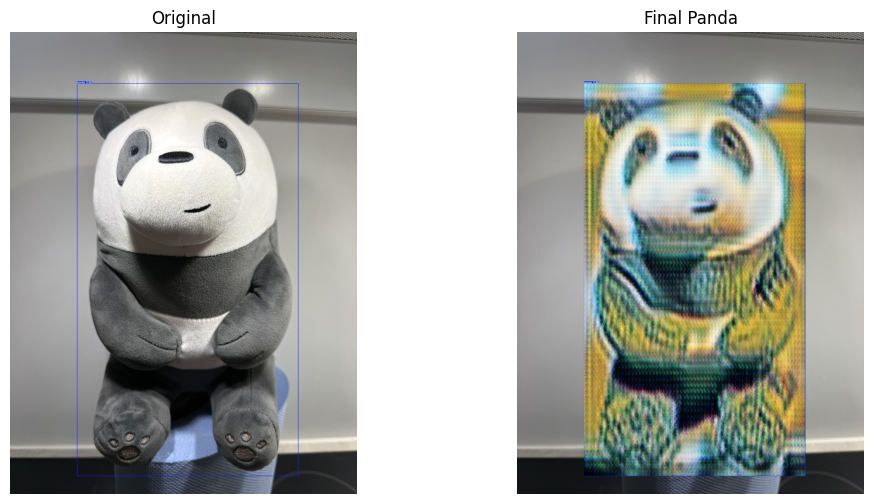

In [46]:
example = "IMG_2085"

orig = Image.open(IMAGE_DIR / f"{example}.JPG")
final = Image.open(FINAL_DIR / f"{example}_final.jpg")

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(final)
plt.title("Final Panda")
plt.axis("off")

plt.show()
